In [1]:
from sklearn.linear_model import LogisticRegression
from apl.prep.prep import preprocess, operations
from apl.prep.ohe import fitted_ohe
from apl.model.log_reg import (get_data, plot_learning_curve, 
                               bias_variance)
import matplotlib.pyplot as plt

In [2]:
df, xtrain, xtest, ytrain, ytest = get_data()
# fit ohe over all data
ohe = fitted_ohe(operations['oneHotEncode'], df)
preprocessor = preprocess(operations, ohe, scale=True)
xtrain = preprocessor.fit_transform(xtrain)
xtest = preprocessor.transform(xtest)
clf = LogisticRegression(penalty='l1', solver='liblinear')

reading  /home/pranay/Desktop/apple/apl/data/data_exercise2.csv
fitting...
transforming...
transforming...


[learning_curve] Training set sizes: [ 274  891 1509 2126 2744]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    5.1s finished


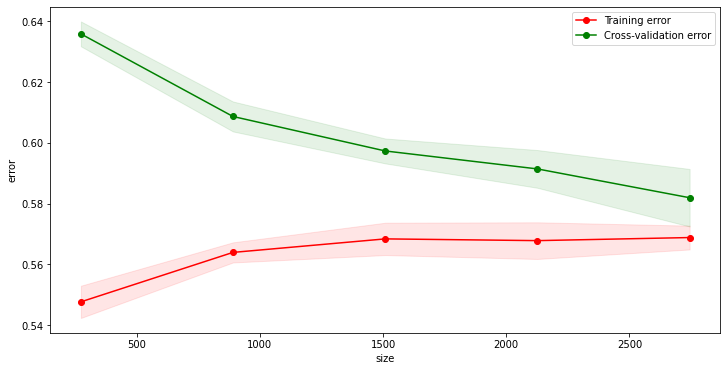

In [3]:
plot_learning_curve(clf, xtrain, ytrain) # Thus, no need of more data

# bias-variance
good values of :

lambda = 0.1, 0.01, 0.001 or

C = 10, 100 

resembles trivial case : all coeff 0

In [ ]:
bias_variance(clf, xtrain, ytrain)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
clf = LogisticRegression(penalty='l1', solver='liblinear')
clf.fit(xtrain, ytrain)
# print(clf.coef_)
# ypred = clf.predict(xtrain)
ypred = clf.predict(xtest)

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
rep = classification_report(ytest, ypred, output_dict=True)
pd.DataFrame(rep).T

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
disp = plot_precision_recall_curve(clf, xtest, ytest)

In [ ]:
plt.figure(figsize=(12,5))
p = xtest.dot(clf.coef_[0])
zero = p[ytest.values==0]
one = p[ytest.values==1]
plt.hist(zero.values, label='0s',color='b',  edgecolor='k', bins=50, alpha=0.5)#, range=(0,1))
plt.hist(one.values, label='1s', color='r', edgecolor='k', bins=50, alpha=0.5)#, range=(0,1))
plt.legend();

In [ ]:
# investigating gaussian
plt.figure(figsize=(12,5))
good_ones = xtest.loc[one[one>1].index]
good_zero = xtest.loc[zero[zero<1].index]
one_vals = clf.coef_*good_ones
zero_vals = clf.coef_*good_zero
plt.hist(zero_vals.sum(axis=1), label='0s',color='b',  edgecolor='k', bins=50, alpha=0.5)#, range=(0,1))
plt.hist(one_vals.sum(axis=1), label='1s', color='r', edgecolor='k', bins=50, alpha=0.5)#, range=(0,1))
plt.legend()

In [ ]:
i = one_vals.mean().reset_index()
i.sort_values(0, ascending=False, inplace=True)
i.columns = ['feature', 'importance']

In [ ]:
i

In [ ]:
xtest.MODULE3_PHASE_4.value_counts()

In [ ]:
xtest.MODULE2_Vendor_2.value_counts()